In [33]:
from sys import path 
path.append("../../")
%matplotlib inline

<a id="top"></a>
# UN SDG Indicator 11.3.1:<br> Ratio of land consumption rate to population growth rate



<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator `11.3.1 - Ratio of land consumption rate to population growth rate`.

11.3.1 provides a metric for determining wether or not land consumption is scaling responsibly with the growth of the  population in a given region.  

### Case Study

This notebook conducts analysis in the **Urban Western regions of Sierra Leone** with reference years of `2015` and `2005`.  


### Figures and formulas

The formulas below outline the calculation of SDG 11.3.1, and are based on reference material published by the [United Nations Economic and Social Comission for Asia and the Pacific](https://www.unescap.org/sites/default/files/Module%203_Land%20Consumption%20Rate%20to%20Population%20Growth%20Rate%20for%20indicator%2011.3.pdf)  

<br>  
<br>


>### SDG Indicator 11.3.1
> The ratio between land consumption and population growth rate.   

$$ SDG_{11.1.3} = \frac{LandConsumptionRate}{PopulationGrowthRate} $$

<br>  

In [34]:
def sdg_11_3_1(land_consumption, population_growth_rate): 
    return land_consumption/population_growth_rate


>### Population Growth rate

$$ PopulationGrowthRate = \frac{LN(  Pop_{t_2} \space / \space  Pop_{t_1}  )}{y} $$  
  
Where:  

- $Pop_{t_2}$ - Total population within the area in the current/final year
- $Pop_{t_1}$ - Total population within the area in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t\space2} - Year_{t\space1}$ 


<br>


In [35]:
import numpy as np  

def population_growth_rate(pop_t1 = None, pop_t2 = None, y = None): 
    return np.log(pop_t2/pop_t1)/y


>### Land Consumption Rate


$$ LandConsumptionRate = \frac{ LN ( \frac{area_{t2}}{area_{t1}})}{y} $$

Where:  

- $area_{t_2}$ - Total area considered to be *urbanized* in the current/final year
- $area_{t_1}$ - Total area considered to be *urbanized* in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t\space2} - Year_{t\space1}$ 



In [36]:
def land_consumption_rate(area_t1 = None, area_t2 = None, y = None):
    return np.log(area_t2 / area_t1)/y

  <br>
<br>  

# Case Study:  Western Urban Region of Sierra Leone 
<br>

Sierra Leone is divided into four regions North, South, East, and West. This case study focuses on the urbanized western region of Sierra Leone near Freetown. Extents are known a priori and will change depending on region. 

>### Area Extents  

In [37]:
latitude_extents = (8.38812501241685, 8.578445590286002)
longitude_extents = (-13.308345055763038, -13.047416896562055)

<br>

In [38]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

> ### Times

In [39]:
T1 = "2005-01-01"
T2 = "2015-01-01"

<br>

# Sierra Leone Population Data
Shape files are based on GPW estimates.You can derive similar population figures from: 
- http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev10

In [40]:
SHAPE_FILE_PATH = "./data/population_shape/gpwv41_sle.shp"

> ### Import Population Data

In [41]:
import geopandas as gpd
country_data = gpd.read_file(SHAPE_FILE_PATH)

In [42]:
country_data = country_data.assign(is_western = country_data.NAME1.str.contains("Western"))

>### Western Region

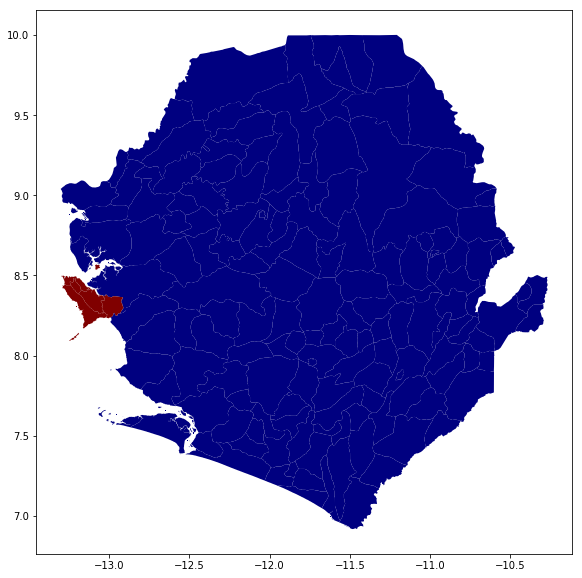

In [43]:
country_data.plot(column = "is_western", cmap = "jet", figsize = (10,10)) 

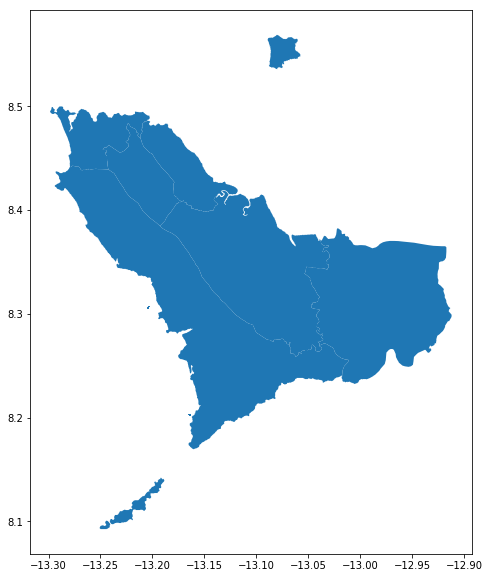

In [44]:
western_region = country_data[country_data.is_western == True]
western_region.plot( figsize = (10,10))

>### Urban Western

In [45]:
western_region = western_region.assign(is_urban = western_region.NAME2.str.contains("Urban"))

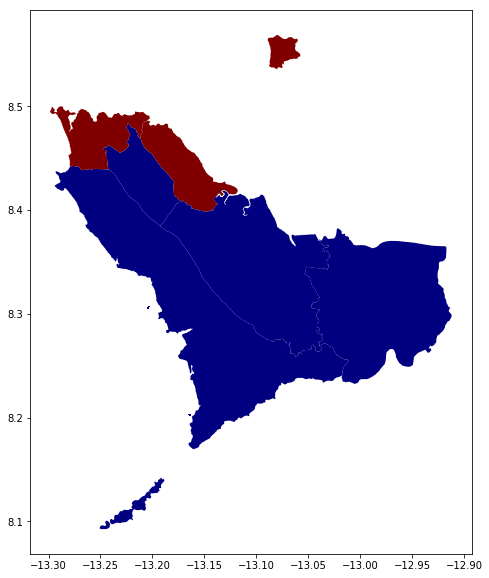

In [46]:
western_region.plot(column = "is_urban", cmap = "jet", figsize = (10,10))

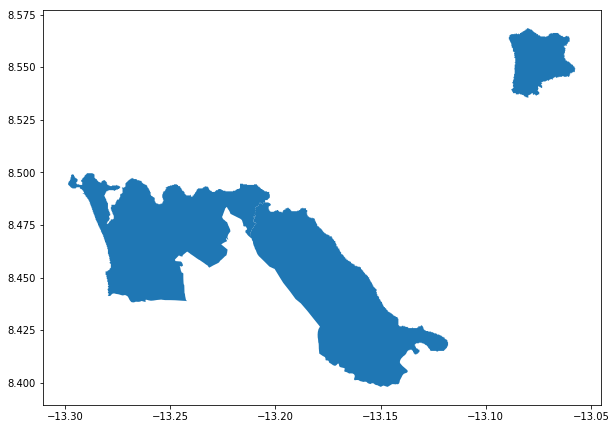

In [47]:
survey_region = western_region[western_region.is_urban == True]
survey_region.plot(figsize = (10,10))

# Population Change  

> **Calcuate Population Growth Rate for all regions**

In [48]:
country_data = country_data.assign(population_growth_rate = np.log(country_data["UN_2015_E"]/country_data["UN_2005_E"])/10)

> ### Population Growth rate

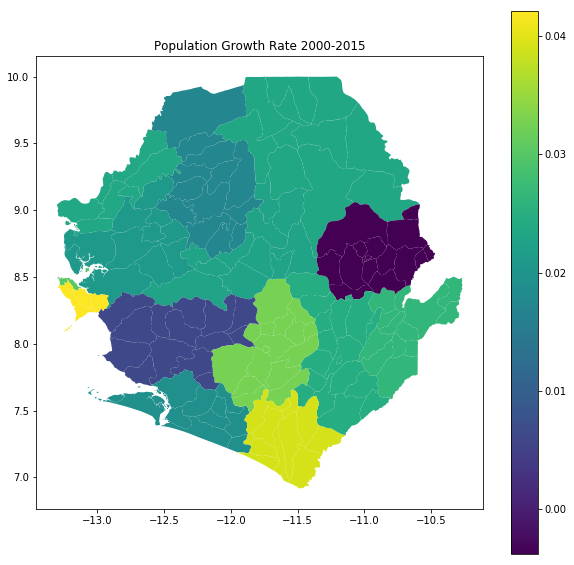

In [49]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize  = (10, 10))
ax.set_title("Population Growth Rate 2000-2015")

ax1 = country_data.plot(column = "population_growth_rate", ax = ax, legend=True)

In [50]:
survey_region_total_pop_2005 = survey_region["UN_2005_E"].sum()
survey_region_total_pop_2015 = survey_region["UN_2015_E"].sum()

In [51]:
pop_growth = population_growth_rate(pop_t1= survey_region_total_pop_2005,
                                    pop_t2 =survey_region_total_pop_2015,
                                    y = 10)

In [52]:
pop_growth

0.030260868963025194

# Land Consumption Rate


> #### Load Landsat Imagery

In [53]:
import datacube
dc = datacube.Datacube()

In [54]:
product = "ls7_ledaps_sierra_leone" 
measurements =  ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
EPSG = "EPSG:4326"
times = [T1, T2]

In [55]:
load_params = dict(product = product,
                      measurements = measurements,
                      latitude = latitude_extents,
                      longitude = longitude_extents)

In [56]:
dataset_t1 =  dc.load( **load_params,
                      time = (np.datetime64(T1), np.datetime64(T1) + np.timedelta64(366, 'D')))

dataset_t2 =  dc.load( **load_params,
                      time = (np.datetime64(T2), np.datetime64(T2) + np.timedelta64(366, 'D')))


> ####  Build Composite for the years of 2005 and 2015

In [57]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

In [58]:
clean_mask_t1 = landsat_qa_clean_mask(dataset_t1, "LANDSAT_7")
clean_mask_t2 = landsat_qa_clean_mask(dataset_t2, "LANDSAT_7")

composite_t1 = create_median_mosaic(dataset_t1, clean_mask_t1)
composite_t2 = create_median_mosaic(dataset_t2, clean_mask_t2)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


> ### 2005:
> False Color Composite [nir, swir1, blue]

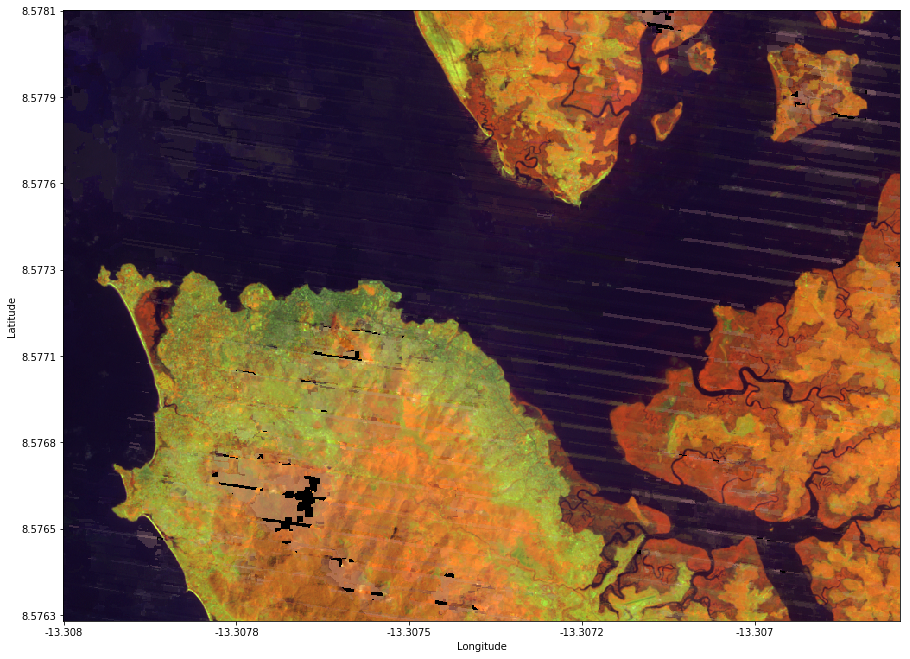

In [59]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(composite_t1, bands = ["nir","swir1","blue"],width = 15)

> ### 2015
> False Color Composite [nir, swir1, blue]

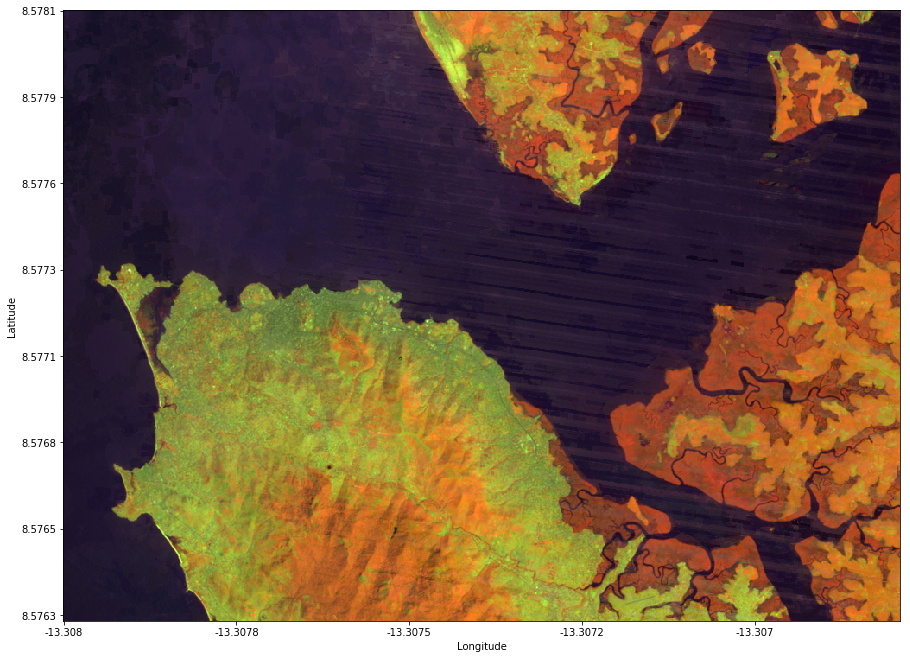

In [60]:
rgb(composite_t2, bands = ["nir","swir1","blue"],width = 15)

> ####  Filtered

In [61]:
from shapely.ops import cascaded_union
disjoint_areas = cascaded_union([*survey_region.dissolve(by = ["is_urban", "is_western"]).geometry]) ## Top Right is 'disjoint' from bottom left.  

In [62]:
import rasterio.features
from datacube.utils import geometry
import xarray as xr

def generate_mask(loaded_dataset:xr.Dataset,
                  geo_polygon: datacube.utils.geometry ):
    
    return rasterio.features.geometry_mask(
                                [geo_polygon],
                                out_shape = loaded_dataset.geobox.shape,
                                transform = loaded_dataset.geobox.affine,
                                all_touched = False,
                                invert = True)

In [63]:
mask = generate_mask(dataset_t1, disjoint_areas)

In [64]:
filtered_composite_t1 = composite_t1.where(mask)
filtered_composite_t2 = composite_t2.where(mask)

> ### 2005

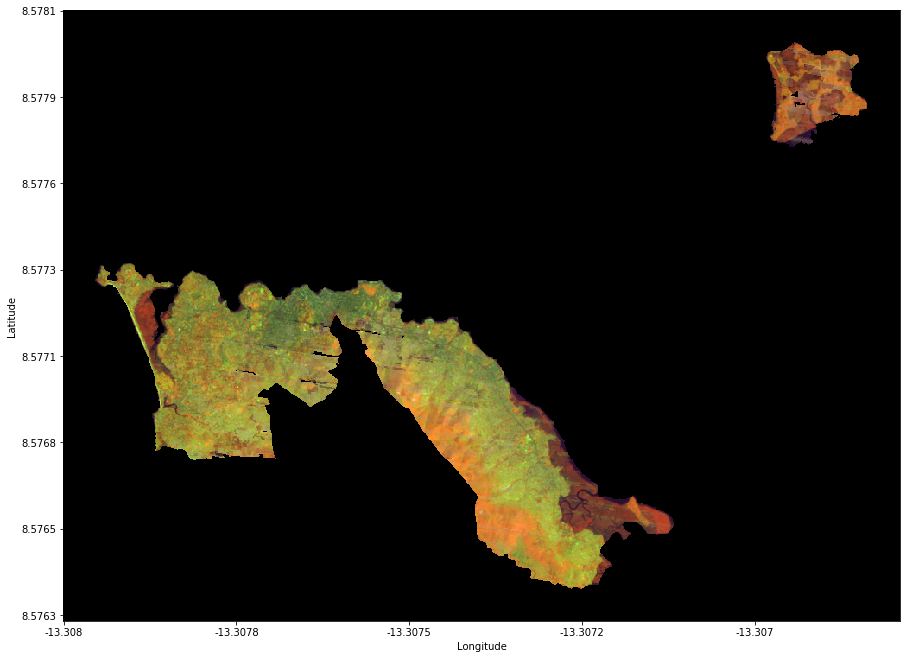

In [65]:
rgb(filtered_composite_t1, bands = ["nir","swir1","blue"],width = 15)

> ### 2015

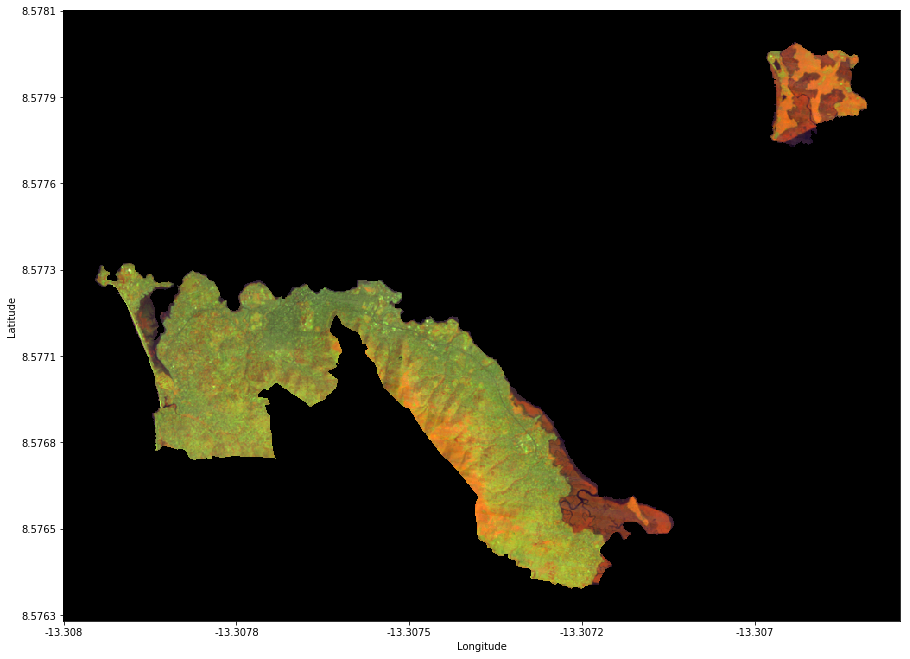

In [66]:
rgb(filtered_composite_t2, bands = ["nir","swir1","blue"],width = 15)

> ####  Urbanization

In [67]:
alpha = 0.30

> ### NDBI  
> A thresholded built up index is used as a proxy for determining urbanization extent. 

In [68]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

> **NDBI Composite 2005**

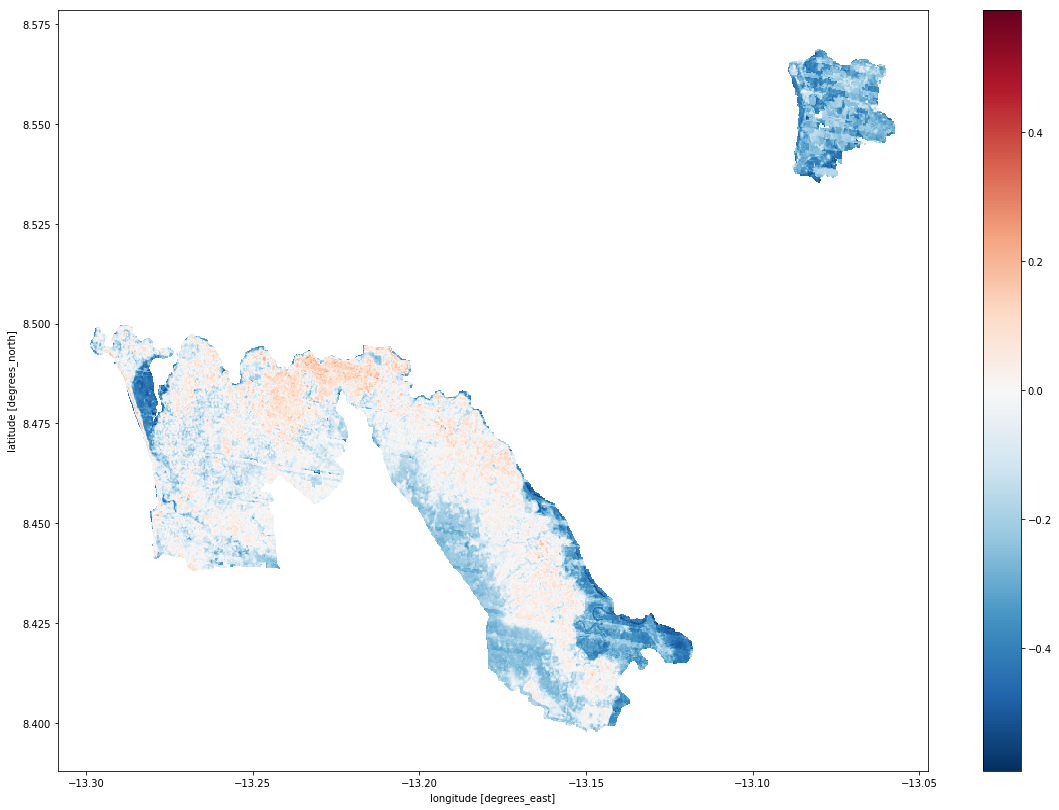

In [69]:
plt.figure(figsize = (19.5, 14))
NDBI(filtered_composite_t1).plot()

> **NDBI Composite 2015**

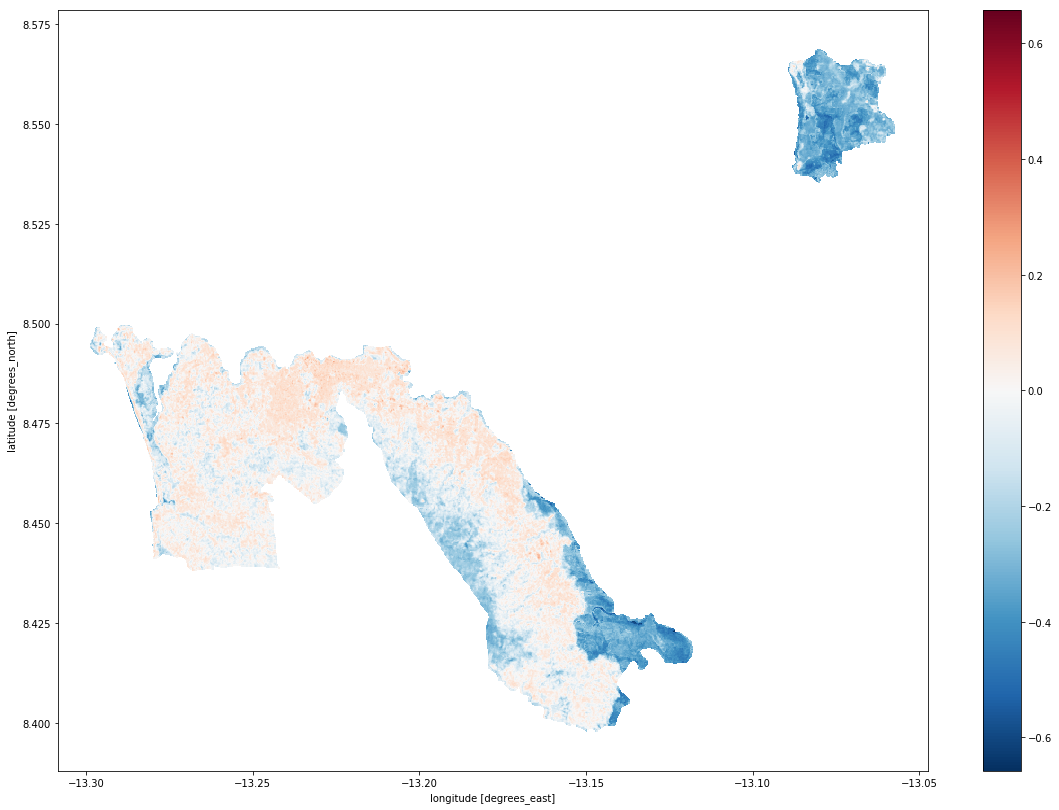

In [70]:
plt.figure(figsize = (19.5, 14))
NDBI(filtered_composite_t2).plot()

> ### Defining Urbanization 

In [80]:
def urbanizaton(landsat_dataset: xr.Dataset , *args, **kwargs) -> xr.DataArray:
    ndbi_bounds = (0,0.3)
    
    ndbi = NDBI(landsat_dataset)    
    urban =  np.logical_and(ndbi > min(ndbi_bounds) , ndbi < max(ndbi_bounds))
    
    is_clean = np.isfinite(ndbi)
    urban = urban.where(is_clean)
    
    return urban

In [81]:
urban_product_t1 = urbanizaton(filtered_composite_t1)
urban_product_t2 = urbanizaton(filtered_composite_t2)

> ### 2005 
> Urbanization Product overlayed on false color composite 

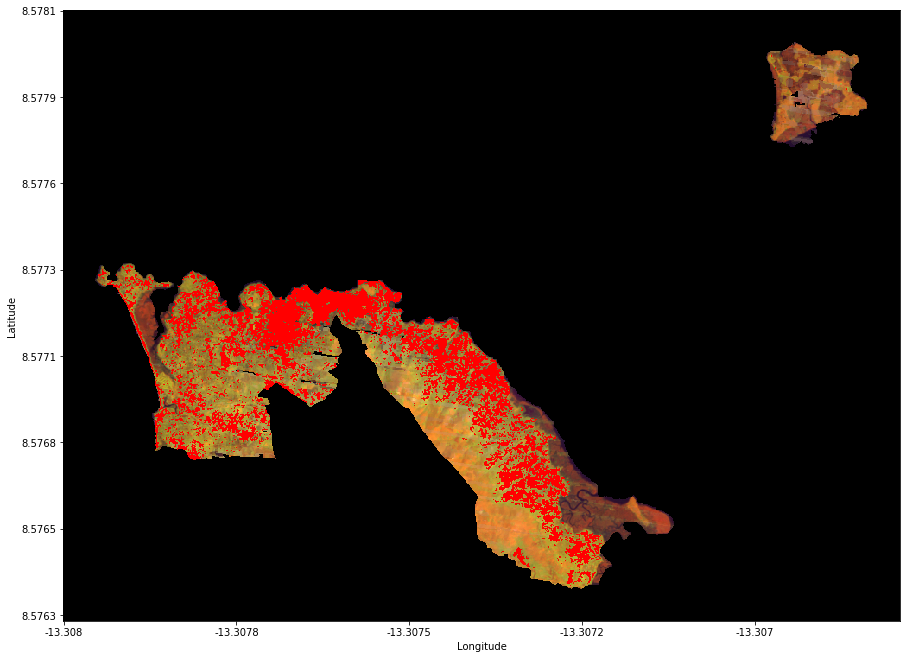

In [82]:
rgb(filtered_composite_t1, 
           bands = ["nir","swir1","blue"], 
           paint_on_mask = [(np.logical_and(urban_product_t1.astype(bool), mask), [255,0,0])],
           width = 15)

> ### 2015 
> Urbanization Product overlayed on false color composite 

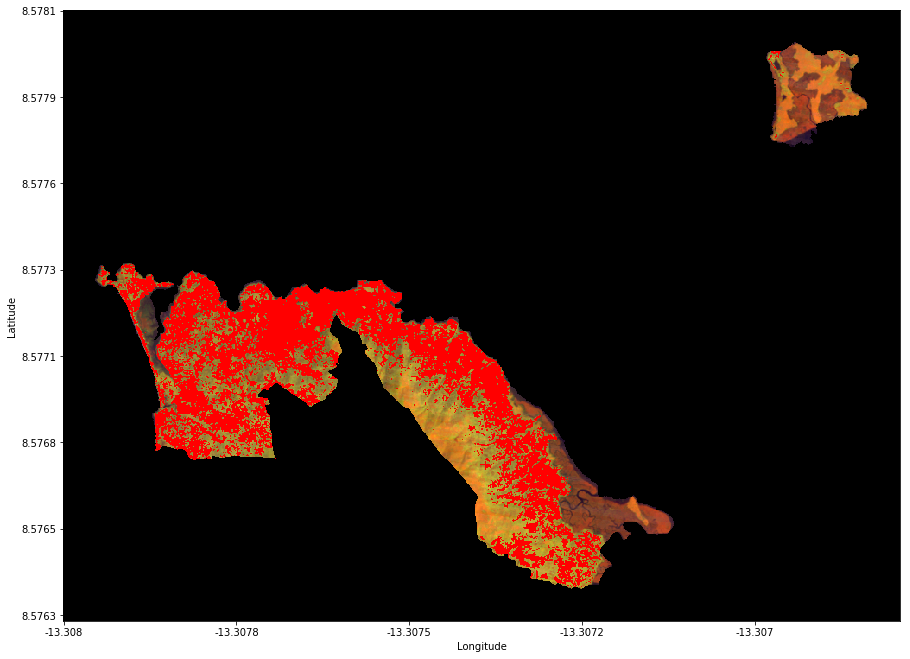

In [83]:
rgb(filtered_composite_t2,
    bands = ["nir","swir1","blue"],
    paint_on_mask = [(np.logical_and(urban_product_t2.astype(bool), mask),[255,0,0])],
    width = 15)

> ##  Urbanization Change

Text(0.5,1,'Urbanization Extent 2015')

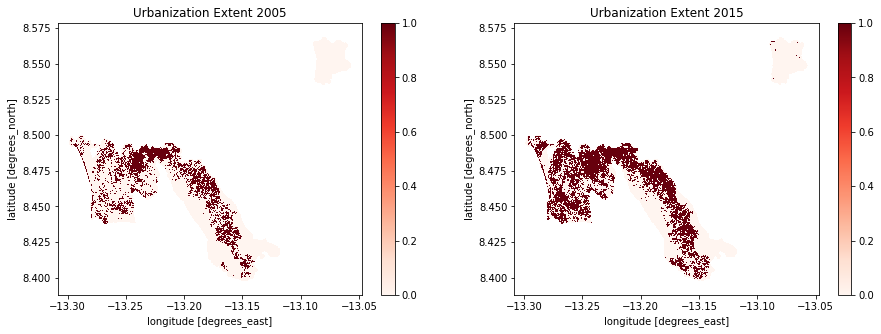

In [84]:
fig = plt.figure(figsize = (15,5))

#T1 (LEFT)
ax1 = fig.add_subplot(121)
urban_product_t1.plot(cmap = "Reds")
ax1.set_title("Urbanization Extent 2005")

#T2 (RIGHT)
ax2 = fig.add_subplot(122)
urban_product_t2.plot(cmap = "Reds")
ax2.set_title("Urbanization Extent 2015")

In [85]:
urbanized_area_t1 = float(  urban_product_t1.sum()  )
urbanized_area_t2 = float(  urban_product_t2.sum()  )

In [86]:
consumption_rate = land_consumption_rate(area_t1 = urbanized_area_t1, area_t2 = urbanized_area_t2, y = 10)

In [87]:
consumption_rate

0.047875138082158784

>### SDG Indicator 11.3.1

In [88]:
sdg_11_3_1(consumption_rate,pop_growth)

1.5820807439685858